Authors: Bhadra Tendulkar (t.bhadra@iitg.ac.in) , Swastik Swaroop (s.swastik@iitg.ac.in), Ayush Jain (ayush.cl21@iitg.ac.in), Abhijit Pandey (p.abhijit@iitg.ac.in)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
import math
import time
import lightgbm as lgb
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

tqdm.pandas()

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('submission.csv')

In [22]:
train['order_time']

0        2021-01-26 02:21:35
1        2021-01-26 02:33:16
2        2021-01-26 02:39:49
3        2021-01-26 02:47:53
4        2021-01-26 03:06:30
                 ...        
449995   2021-02-06 10:03:16
449996   2021-02-06 10:03:17
449997   2021-02-06 10:03:18
449998   2021-02-06 10:03:19
449999   2021-02-06 10:03:24
Name: order_time, Length: 450000, dtype: datetime64[ns]

In [26]:
train.columns

Index(['order_time', 'order_date', 'allot_time', 'accept_time', 'pickup_time',
       'delivered_time', 'rider_id', 'first_mile_distance',
       'last_mile_distance', 'alloted_orders', 'delivered_orders', 'cancelled',
       'undelivered_orders', 'lifetime_order_count', 'reassignment_method',
       'reassignment_reason', 'reassigned_order', 'session_time',
       'cancelled_time'],
      dtype='object')

In [7]:
id_columns = ['order_id']

time_columns = ['order_time', 'order_date', 'allot_time', 'accept_time',
       'pickup_time', 'delivered_time','cancelled_time']

categorical_columns = ['reassignment_method','reassignment_reason']

# Converting to datetime and object


In [10]:
ids = train[id_columns]
train = train.drop(ids, axis=1)
test = test.drop(ids,axis=1)

for col in time_columns:
    train[col] = pd.to_datetime(train[col])
    try:
        test[col] = pd.to_datetime(test[col])
    except:
        continue

for col in categorical_columns:
    train[col] = train[col].astype('object')
    try:
        test[col] = test[col].astype('object')
    except:
        continue


# Preprocessing

In [13]:
def peak_hour(x):
    if x>=8 and x<=11:
        return 1
    if x>=13 and x<=19:
        return 1
    return 0

def log_normal(x):
    if x==0:
        return 0
    if x>0:
        return math.log(x)
    else:
        return math.log(abs(x))

In [52]:
def preprocess(df):
    df = df.copy()  # Ensure we're working on a copy
    df.loc[:, 'order_day'] = df['order_date'].dt.dayofyear
    df.loc[:, 'diff_allot_order'] = (df['allot_time'] - df['order_time']).dt.total_seconds()
    df.loc[:, 'diff_accept_allot'] = (df['accept_time'] - df['allot_time']).dt.total_seconds()
    df.loc[:, 'diff_accept_order'] = (df['accept_time'] - df['order_time']).dt.total_seconds()
    df.loc[:, 'total_dist'] = df['first_mile_distance'] + df['last_mile_distance']
    df.loc[:, 'hour_in_day'] = df['order_time'].dt.hour
    df.loc[:, 'day_of_week'] = df['order_date'].dt.dayofweek

    # Group and cumulative sum
    df[['cum_diff_allot_order', 'cum_diff_accept_allot', 'cum_diff_accept_order',
        'cum_total_dist', 'cum_first_mile_dist', 'cum_last_mile_dist']] = df.groupby(
        ['rider_id', 'order_date'])[['diff_allot_order', 'diff_accept_allot',
                                     'diff_accept_order', 'total_dist',
                                     'first_mile_distance', 'last_mile_distance']].cumsum()

    df.loc[:, 'order_today'] = df.groupby(['rider_id', 'order_date']).cumcount()
    df.loc[:, 'orders_cum'] = df.groupby(['rider_id']).cumcount()
    df.loc[:, 'reassigned_order'] = df['reassigned_order'].fillna(0)
    df.loc[:, 'saturday'] = df['day_of_week'].apply(lambda x: 1 if x == 5 else 0)

    for col in ['alloted_orders', 'delivered_orders', 'undelivered_orders']:
        df[col] = df[col].fillna(0)

    df.loc[:, 'orders_diff'] = df['alloted_orders'] - df['delivered_orders']
    df.loc[:, 'riders_available'] = df.groupby(['order_date', 'hour_in_day'])['rider_id'].transform('count')
    df.loc[:, 'reliability'] = ((df['alloted_orders'] - df['undelivered_orders']) * 100 / df['alloted_orders']).fillna(0)

    cols = ['diff_allot_order', 'diff_accept_allot', 'diff_accept_order']
    df.loc[:, 'mean'] = df[cols].mean(axis=1)
    df.loc[:, 'std'] = df[cols].std(axis=1)
    df.loc[:, 'min'] = df[cols].min(axis=1)
    df.loc[:, 'max'] = df[cols].max(axis=1)

    return df


# Train Valid Split

In [55]:
train_df = train[:395778].copy()
valid_df = train[395778:].copy()
train_df = preprocess(train_df)
valid_data = preprocess(valid_df)
test_df= preprocess(test)

### Rider details feature engineering

In [60]:
import pandas as pd

# Separate numeric columns and datetime columns
numeric_cols = df[rider_cols_mean].select_dtypes(include=[int, float]).columns
datetime_cols = df[rider_cols_mean].select_dtypes(include=[np.datetime64]).columns

# Calculate cumulative sum only for numeric columns
numeric_cumsum = df.groupby('rider_id')[numeric_cols].cumsum()

# Handle datetime columns if needed (example: cumulative count instead of cumsum)
datetime_cumsum = df.groupby('rider_id')[datetime_cols].cumcount()

# Combine the results
data = pd.concat([numeric_cumsum, datetime_cumsum], axis=1)

# Calculate cumulative means
data['cumcounts'] = df.groupby('rider_id').cumcount() + 1
for i in numeric_cols:
    data[i] = data[[i, 'cumcounts']].progress_apply(lambda x: x[i] / x['cumcounts'], axis=1)


100%|██████████| 594844/594844 [00:05<00:00, 115747.30it/s]


In [62]:
rider_deets = data.copy()
rider_deets

,session_time,first_mile_distance,last_mile_distance,total_dist,0,cumcounts
0,NaN,1.566600,2.650000,4.216600,0,1
1,3.266667,2.520700,2.760000,5.280700,0,1
2,9.816667,2.207400,4.800000,7.007400,0,1
3,17.533333,2.189400,6.380000,8.569400,0,1
4,1.350000,2.787000,4.010000,6.797000,0,1
...,...,...,...,...,...,...
144839,137.422523,1.766382,2.750000,4.516382,36,37
144840,411.332222,0.460262,1.067333,1.360795,29,30
144841,121.676190,0.996990,2.565571,3.562562,69,70
144842,456.847764,1.200194,2.513780,3.713974,81,82


In [64]:
time_columns = ['order_time', 'order_date', 'allot_time', 'accept_time',
       'pickup_time', 'delivered_time','cancelled_time']
numerical_columns = ['first_mile_distance',
       'last_mile_distance', 'alloted_orders', 'delivered_orders', 'lifetime_order_count',
                    'session_time','diff_allot_order', 'diff_accept_allot',
       'diff_accept_order', 'total_dist','cum_diff_allot_order', 'cum_diff_accept_allot',
       'cum_diff_accept_order', 'cum_total_dist', 'allotted_orders',
                     'riders_available','orders_cum','reliability']
categorical_columns = ['reassignment_method','reassignment_reason','reassigned_order','order_day','hour_in_day','undelivered_orders','day_of_week',
                       'order_today', 'allotted', 'deliveries','period_in_day','saturday','first_mile', 'last_mile','orders_diff']

# Undersampling negative class and combining

In [67]:
train_df_c = train_df[train_df['cancelled']==1].sample(int(train_df[train_df['cancelled']==1].shape[0]*1),replace=False,random_state=42)
train_df_d = train_df[train_df['cancelled']==0].sample(int(train_df_c.shape[0])*1,random_state=42)

In [69]:
combined_df = pd.concat([train_df_c,train_df_d])
combined_df = combined_df.sort_values('order_time')

In [71]:
cols = ['first_mile_distance',
       'last_mile_distance', 'alloted_orders', 'delivered_orders',
       'undelivered_orders', 'lifetime_order_count',
       'session_time',
       'order_day', 'diff_allot_order', 'diff_accept_allot',
       'diff_accept_order', 'total_dist', 'hour_in_day', 'day_of_week','cum_diff_allot_order', 'cum_diff_accept_allot',
       'cum_diff_accept_order','reassigned_order',
       'cum_total_dist', 'order_today','rider_id','orders_cum',
       'saturday','orders_diff','riders_available','cum_first_mile_dist','cum_last_mile_dist','reliability','mean','std','min','max']

# Combining datasets with details about the rider

In [74]:
combined_df = combined_df[cols+['cancelled']]
combined_df = pd.merge(combined_df,rider_deets[:-test_df.shape[0]],left_index=True,right_index=True)

X_train = combined_df.drop('cancelled',axis=1)
y_train = combined_df['cancelled']


valid_df = valid_data[cols+['cancelled']]
valid_df = pd.merge(valid_df,rider_deets[:-test_df.shape[0]],left_index=True,right_index=True)

X_test = valid_df.drop('cancelled',axis=1)
y_test = valid_df['cancelled']

# Predictions using Random Forests Classifier

In [87]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Define the parameters for the RandomForestClassifier
params = {
    'n_estimators': 900,
    'max_depth': 40,
    'random_state': 2020,
    'min_samples_split': 10,
    'min_samples_leaf': 2
}

# Initialize and fit the RandomForestClassifier
rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)

# Make predictions
rf_preds = rf.predict(X_test)
rf_preds_prob = rf.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     53618
           1       0.04      0.54      0.07       604

    accuracy                           0.85     54222
   macro avg       0.52      0.69      0.49     54222
weighted avg       0.98      0.85      0.91     54222

Test Accuracy:  0.8467596178672864
Train Accuracy:  0.9855873428695275
AUC Score: 0.7418450275792032


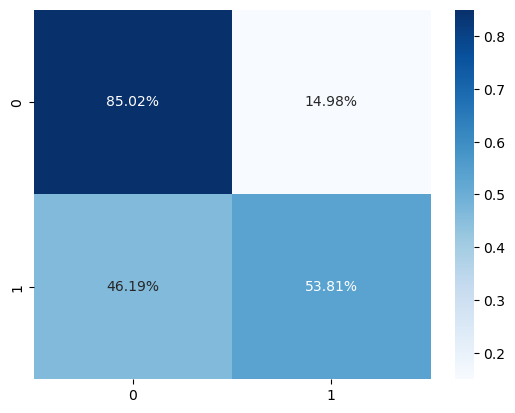

In [89]:
result = confusion_matrix(y_test, rf_preds)
r = np.sum(result,axis=1)
a,b,c,d=result[0][0]/r[0],result[0][1]/r[0],result[1][0]/r[1],result[1][1]/r[1]
sns.heatmap([[a,b],[c,d]], annot=True, fmt=".2%", cmap='Blues')
print(classification_report(y_test,rf_preds))
print('Test Accuracy: ',rf.score(X_test,y_test))
print('Train Accuracy: ',rf.score(X_train,y_train))
print('AUC Score:',roc_auc_score(y_test,rf_preds_prob))

# XGBoost Classifier

In [98]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Define the parameters for the XGBClassifier
params = {
    'lambda': 0.20177241158844367,
    'alpha': 3.4670054832209787,
    'colsample_bytree': 0.8,
    'subsample': 0.6,
    'learning_rate': 0.02,
    'max_depth': 5,
    'random_state': 48,
    'min_child_weight': 37,
    'eval_metric': 'auc'  # Add eval_metric here
}

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier(**params)

# Fit the model with eval_set to monitor performance
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Make predictions
xgby_pred = xgb_model.predict(X_test)
xgby_preds_prob = xgb_model.predict_proba(X_test)[:, 1]


[0]	validation_0-auc:0.73473	validation_1-auc:0.69530
[1]	validation_0-auc:0.74416	validation_1-auc:0.71329
[2]	validation_0-auc:0.75367	validation_1-auc:0.72785
[3]	validation_0-auc:0.75283	validation_1-auc:0.72594
[4]	validation_0-auc:0.75595	validation_1-auc:0.72901
[5]	validation_0-auc:0.75783	validation_1-auc:0.73088
[6]	validation_0-auc:0.76118	validation_1-auc:0.73090
[7]	validation_0-auc:0.76244	validation_1-auc:0.72925
[8]	validation_0-auc:0.76392	validation_1-auc:0.72925
[9]	validation_0-auc:0.76518	validation_1-auc:0.73130
[10]	validation_0-auc:0.76603	validation_1-auc:0.73108
[11]	validation_0-auc:0.76631	validation_1-auc:0.73218
[12]	validation_0-auc:0.76694	validation_1-auc:0.73244
[13]	validation_0-auc:0.76682	validation_1-auc:0.73174
[14]	validation_0-auc:0.76626	validation_1-auc:0.73189
[15]	validation_0-auc:0.76633	validation_1-auc:0.73291
[16]	validation_0-auc:0.76655	validation_1-auc:0.73302
[17]	validation_0-auc:0.76642	validation_1-auc:0.73259
[18]	validation_0-au

Classification Report:
Train Accuracy:  0.7170567837017772
Test Accuracy: 0.8758253107594703
AUC Score: 0.743357767691437


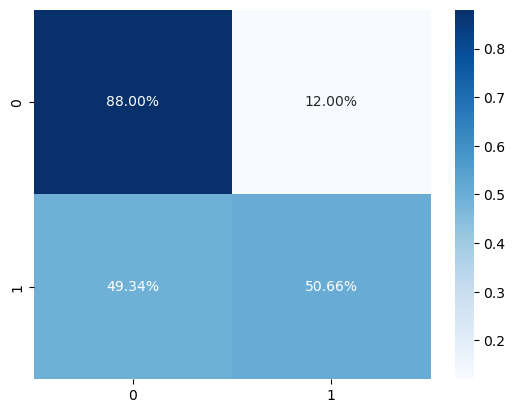

In [100]:
result = confusion_matrix(y_test, xgby_pred)
r = np.sum(result,axis=1)
a,b,c,d=result[0][0]/r[0],result[0][1]/r[0],result[1][0]/r[1],result[1][1]/r[1]
sns.heatmap([[a,b],[c,d]], annot=True, fmt=".2%", cmap='Blues')
result1 = classification_report(y_test, xgby_pred)
print("Classification Report:",)
result2 = accuracy_score(y_test,xgby_pred)
print('Train Accuracy: ',xgb_model.score(X_train,y_train))
print("Test Accuracy:",result2)
print('AUC Score:',roc_auc_score(y_test,xgby_preds_prob))

[[46531  7087]
 [  291   313]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     53618
           1       0.04      0.52      0.08       604

    accuracy                           0.86     54222
   macro avg       0.52      0.69      0.50     54222
weighted avg       0.98      0.86      0.92     54222

AUC Score:  0.7449049679125747


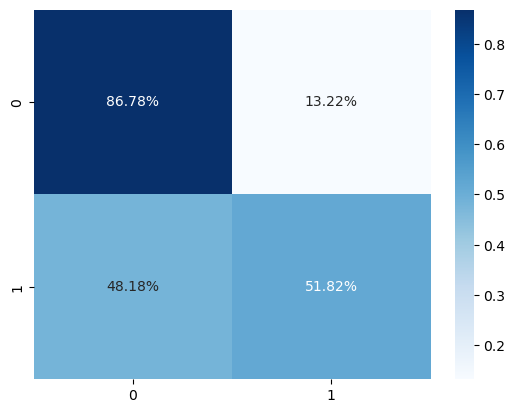

In [102]:
check = pd.DataFrame()
check['rf_pred'] = rf_preds_prob
check['xgb_pred'] = xgby_preds_prob
check['sums'] = check[['rf_pred','xgb_pred']].mean(axis=1)
check['cancelled'] = y_test.reset_index()['cancelled']
check['pred'] = check['sums'].apply(lambda x: 1 if x>=0.5 else 0)
result = confusion_matrix(y_test, check['pred'])
print(result)
a,b,c,d=result[0][0]/r[0],result[0][1]/r[0],result[1][0]/r[1],result[1][1]/r[1]
sns.heatmap([[a,b],[c,d]], annot=True, fmt=".2%", cmap='Blues')
print(classification_report(y_test, check['pred']))
print("AUC Score: ",roc_auc_score(y_test,check['sums']))

# Predicting on test data and submission

In [105]:
test_df = test_df[cols]
test_data = pd.merge(test_df,rider_deets[rider_deets.shape[0]//2:],left_index=True,right_index=True)

In [109]:
test_data.columns = test_data.columns.astype(str)
test_data = test_data.reindex(columns=X_train.columns, fill_value=0)
y_preds_rf = rf.predict_proba(test_data)[:, 1]
y_preds_xgb = xgb_model.predict_proba(test_data)[:, 1]